## Find market mispricings like the pros with GARCH

In today’s issue, I’m going to show you how to forecast volatility with GARCH.

Professional options traders don’t make bets that stocks will go up or down. They look for mispricings in the market. Mispricing happens when the market price is different than what a model says the price should be.

If the price of an option is $1.50 and the model shows it should be $1.75, a trader would buy the option “cheap” and wait for it to rise to $1.75.

Derivatives models use volatility to determine the value. So quants spend most of their time building the best volatility forecasts they can to find market mispricings.

And you can use the same tools as the quants.

## GARCH is widely viewed as a better gauge of volatility than the standard deviation

Stock returns have two interesting features that GARCH models well:

1. Variance error terms are autocorrelated (dependent on each other)
2. Periods of high volatility tend to cluster

Dr. Tim Bollerslev developed GARCH in 1986 to address the problem of forecasting volatility in asset prices. It’s used in quant finance for risk management, derivatives pricing, and portfolio optimization.

By the end of this issue, you’ll know how to:

1. Get stock price data
2. Fit a GARCH model
3. Forecast volatility
4. Find mispricings

I’m going to show you how to do it all in Python.

Step by step.

In [8]:
# Step 1: Get stock price data

# Start by importing the libraries and getting the data. I like to use yfinance for getting stock data and NumPy for math functions. I use the excellent library arch to forecast volatility.

# To control plot formatting, set options like figure size and font.

%matplotlib inline
import numpy as np
import yfinance as yf
from arch import arch_model

import matplotlib.pyplot as plt
plt.rc("figure", figsize=(16, 6))
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)
# After the imports, grab some data.

data = yf.download("AAPL", start="2020-01-01", end="2023-03-31")
# Compute the simple returns and multiply by 100 to avoid the scaling warning from arch_model.

adjusted_closes = data['Adj Close']
returns = 100 * adjusted_closes.pct_change().dropna()
returns

[*********************100%***********************]  1 of 1 completed


Date
2020-01-03   -0.972198
2020-01-06    0.796816
2020-01-07   -0.470294
2020-01-08    1.608611
2020-01-09    2.124099
                ...   
2023-03-24    0.830559
2023-03-27   -1.229330
2023-03-28   -0.398032
2023-03-29    1.979074
2023-03-30    0.988988
Name: Adj Close, Length: 816, dtype: float64

In [11]:
# Step 2: Fit a GARCH model

# Fitting a GARCH model is one line of code.

model = arch_model(returns)
# Calling arch_model like this does three things:

# 1. Uses a constant mean
# 2. Assumes a GARCH(1, 0, 1) volatility model
# 3. Uses a normal distribution for the standardized errors

# You can adjust these values – and even build your own mean and variance models – as inputs. Check out the documentation if you’re interested.
# After you define the model, fit it.

res = model.fit()
# The library uses an iterative algorithm called maximum likelihood estimation to fit the model parameters. Details of each iteration prints to the screen.

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4698.811062223758
Iteration:      2,   Func. Count:     16,   Neg. LLF: 62022.328733173825
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2052.040801932415
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1987.6272656971678
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1745.5506418318168
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1745.5299397123176
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1745.528519010563
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1745.528201228984
Iteration:      9,   Func. Count:     58,   Neg. LLF: 1745.5281887964193
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1745.5281887966557
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1745.5281887964193
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10


In [14]:
# Step 3: Forecast volatility
# get the variance forecast
forecast = res.forecast(horizon=1, reindex=False)
variance_forecast = forecast.variance.iloc[-1][0]

# compute the annualized volatility forecast
volatility_forecast = np.sqrt(variance_forecast)
annualized_volatility_forecast = volatility_forecast * np.sqrt(252) / 100
print(annualized_volatility_forecast)

0.24340259835841638


In [15]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1745.53
Distribution:                  Normal   AIC:                           3499.06
Method:            Maximum Likelihood   BIC:                           3517.87
                                        No. Observations:                  816
Date:                Sun, Apr 16 2023   Df Residuals:                      815
Time:                        08:09:41   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2017  7.109e-02      2.838  4.544e-03 [6.240e-02,  0.341]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2172  8.841e-02      2.457  1.401e-02 [4.395e-02,  0.391]
alpha[1]       0.1180  2.878e-02      4.101  4.106e-05 [6.163e-02,  0.174]
beta[1]        0.8390  3.433e-02     24.442 6.172e-132   [  0.772,  0.906]
==========================================================================

Covariance estimator: robust
"""

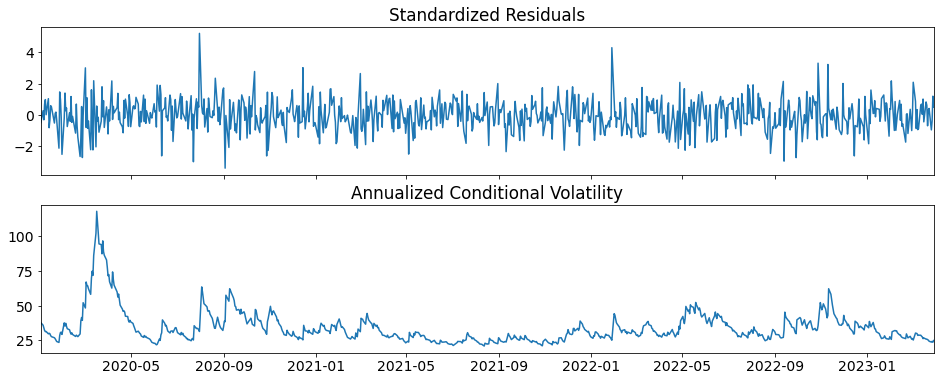

In [13]:
fig = res.plot(annualize='D')